In [6]:
import numpy as np
import cPickle as pickle

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms

from matplotlib.ticker import NullFormatter, ScalarFormatter, NullLocator, AutoLocator, MultipleLocator

class SqrtScale(mscale.ScaleBase):
    # The name under which this scale will be registered with matplotlib.
    name = 'sqrt'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def get_transform(self):
        return self.SqrtTransform()

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(AutoLocator())
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_locator(NullLocator())
        axis.set_minor_formatter(NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(vmin, 0.0), vmax

    class SqrtTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            masked = np.ma.masked_where((a < 0.0), a)
            if masked.mask.any():
                return ma.sqrt(masked)
            else:
                return np.sqrt(a)

        def inverted(self):
            return SqrtScale.InvertedSqrtTransform()

    class InvertedSqrtTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return a**2

        def inverted(self):
            return SqrtScale.SqrtTransform()

mscale.register_scale(SqrtScale)

def plot_regret_curves(ax, info, regret, xscale=None, yscale=None):
    ranker_model_name = info['ranking_model'].getName()
    click_model_name = info['click_model'].getName()
    cutoff = info['cutoff']
    qid = info['query']
    regret = regret.cumsum()
    
    xscale = 'linear' if xscale is None else xscale
    yscale = 'linear' if yscale is None else yscale
    
    # Subsample regret if there is more than 10^5 iterations.
    if regret.shape[0] > 100000:
        indices = np.linspace(0, regret.shape[0] - 1, 100000).astype('int32')
        regret = regret[indices]
    else:
        indices = np.arange(regret.shape[0], dtype='int32')

    ax.set_title('%s - %s@%d - Q%s (%s Regret Plot)' % (ranker_model_name, click_model_name, cutoff, qid,
                                                       xscale.capitalize()  + '-' + yscale.capitalize()))

    ax.plot(indices, regret, 'b-')

    ax.set_ylabel('Regret - (CTR@%d)' % cutoff)
    ax.set_xlabel('Impressions')

    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

    ax.title.set_fontsize(10)

    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)

    ax.xaxis.get_offset_text().set_fontsize(10)
    ax.yaxis.get_offset_text().set_fontsize(10)

    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)

with open('data/model_query_collection.pkl') as ifile:
    MQD = pickle.load(ifile)

# Cumulative Regret Curves for Ranking and Click Model Pairs

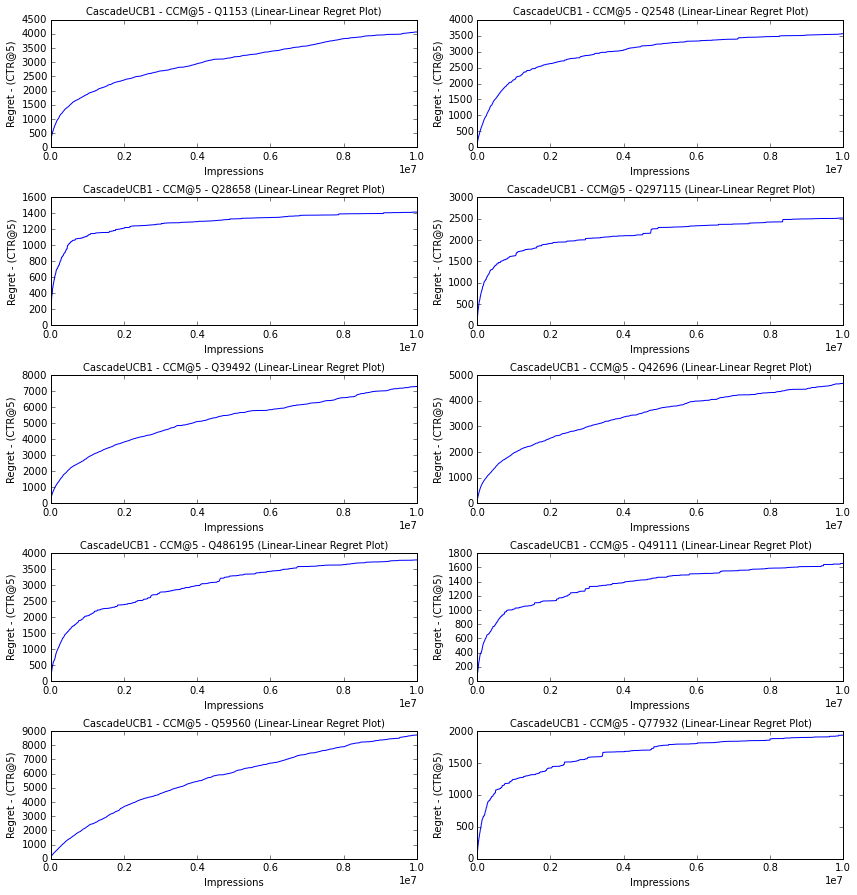

In [9]:
import os
import cPickle as pickle
from ipywidgets import Select, Dropdown, interactive, HBox
from IPython.display import display

def get_regret_filepath(experiment_info_filepath):
    return experiment_info_filepath.rstrip('experiment.nfo') + 'regret.npy'

def show_regrets_widget():
    experiment_filepaths = []
    experiment_specs = []
    
    def show_regrets(ranking_model_name, click_model_name, xscale, yscale):
        spec_indices = [i for i, spec in enumerate(experiment_specs)
                        if spec['click_model'].getName() == click_model_name and
                        spec['ranking_model'].getName() == ranking_model_name and
                        os.path.exists(get_regret_filepath(experiment_filepaths[i]))]
        
        specs = sorted([experiment_specs[i] for i in spec_indices],key=lambda info: info['query'])
        regrets = [np.load(get_regret_filepath(experiment_filepaths[i])) for i in spec_indices]

        n_rows = len(specs) / 2
        n_cols = 2 if len(specs) > 1 else 1
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 2.5 * n_rows))
        
        axes = axes.ravel()
        
        for ax, info, regret in zip(axes, specs, regrets):
            plot_regret_curves(ax, info, regret, xscale=xscale, yscale=yscale)
        plt.tight_layout()
        plt.show()   

    for root, dirs, files in os.walk("experiments", topdown=True):
        for fn in files:
            if fn.endswith('.nfo'):
                fp = os.path.join(root, fn)
                experiment_filepaths.append(fp)
                with open(fp) as ifile:
                    experiment_specs.append(pickle.load(ifile))
    
    ranking_model_names = set([spec['ranking_model'].getName() for spec in experiment_specs])
    click_model_names = set([spec['click_model'].getName() for spec in experiment_specs])

    rmdd = Select(options=list(ranking_model_names), description='Ranking Model:', width='150px')
    cmdd = Select(options=list(click_model_names), description='Click Model:', width='75px')
    xsdd = Select(options=['linear', 'sqrt', 'log'], description='X Scale:', width='100px')
    ysdd = Select(options=['linear', 'sqrt', 'log'], description='Y Scale:', width='100px')
    
    controls = HBox([rmdd, cmdd, xsdd, ysdd])
    backend = interactive(show_regrets, ranking_model_name=rmdd, click_model_name=cmdd,
                          xscale=xsdd, yscale=ysdd)

    controls.on_displayed(lambda _: show_regrets(rmdd.value, cmdd.value, xsdd.value, ysdd.value))

    display(controls)

show_regrets_widget()

# Cumulative Regret Curves for Ranking and Click Model Pairs

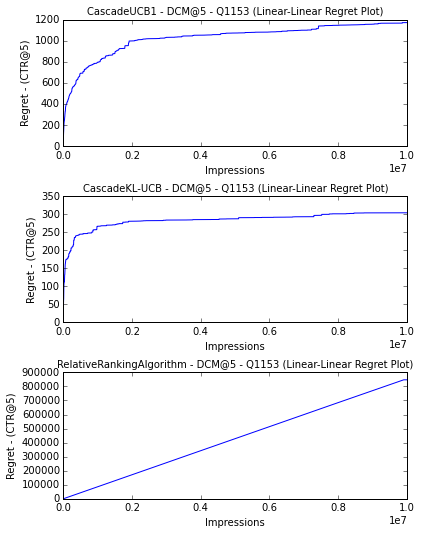

In [3]:
import os
import cPickle as pickle
from ipywidgets import Select, Dropdown, interactive, HBox
from IPython.display import display

def get_regret_filepath(experiment_info_filepath):
    return experiment_info_filepath.rstrip('experiment.nfo') + 'regret.npy'

def show_regrets_widget():
    experiment_filepaths = []
    experiment_specs = []
    
    def show_regrets(query, click_model_name, xscale, yscale):
        spec_indices = [i for i, spec in enumerate(experiment_specs)
                        if spec['click_model'].getName() == click_model_name and
                        spec['query'] == query and
                        os.path.exists(get_regret_filepath(experiment_filepaths[i]))]
        
        specs = [experiment_specs[i] for i in spec_indices]
        regrets = [np.load(get_regret_filepath(experiment_filepaths[i])) for i in spec_indices]

        n_rows = len(specs)
        n_cols = 1 #2 if len(specs) > 1 else 1
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 2.5 * n_rows))
        
        axes = axes.ravel()
        
        for ax, info, regret in zip(axes, specs, regrets):
            plot_regret_curves(ax, info, regret, xscale=xscale, yscale=yscale)
        plt.tight_layout()
        plt.show()   

    for root, dirs, files in os.walk("experiments", topdown=True):
        for fn in files:
            if fn.endswith('.nfo'):
                fp = os.path.join(root, fn)
                experiment_filepaths.append(fp)
                with open(fp) as ifile:
                    experiment_specs.append(pickle.load(ifile))
    
    queries = sorted(set([spec['query'] for spec in experiment_specs]))
    click_model_names = set([spec['click_model'].getName() for spec in experiment_specs])

    qdd = Select(options=list(queries), description='Queries:', width='150px')
    cmdd = Select(options=list(click_model_names), description='Click Model:', width='75px')
    xsdd = Select(options=['linear', 'sqrt', 'log'], description='X Scale:', width='100px')
    ysdd = Select(options=['linear', 'sqrt', 'log'], description='Y Scale:', width='100px')
    
    controls = HBox([qdd, cmdd, xsdd, ysdd])
    backend = interactive(show_regrets, query=qdd, click_model_name=cmdd, xscale=xsdd, yscale=ysdd)

    controls.on_displayed(lambda _: show_regrets(qdd.value, cmdd.value, xsdd.value, ysdd.value))

    display(controls)

show_regrets_widget()

In [4]:
print MQD['UBM']['1153']['model'].get_ideal_ranking()
print MQD['UBM']['1153']['model'].get_ideal_ranking(cutoff=5)
print MQD['UBM']['1153']['model'].p_attraction
Imps = np.load('experiments/RelativeRankingAlgorithm_Horizon10000000/RelativeRankingAlgorithm_UBM_1153_5_10000000_rankings.npy')
print Imps[99999:10000000:100000,:]


[0 2 3 9 8 1 5 7 6 4]
[0 2 3 9 8]
[ 0.45592086  0.33464069  0.38126441  0.36948492  0.22511834  0.30218321
  0.22727837  0.26977274  0.34968721  0.35678549]
[[1 0 9 4 6 8 5 3 7 2]
 [2 6 7 8 1 0 5 3 4 9]
 [3 9 6 5 2 1 8 4 7 0]
 [5 6 2 0 9 8 7 4 1 3]
 [7 6 8 0 9 2 5 3 1 4]
 [1 2 4 0 9 3 6 8 7 5]
 [8 3 2 1 6 9 7 0 5 4]
 [9 1 4 6 0 8 5 7 3 2]
 [8 0 6 4 3 7 9 5 2 1]
 [2 0 3 9 6 4 5 8 1 7]
 [8 5 2 7 1 9 0 3 6 4]
 [4 7 1 8 6 2 0 9 5 3]
 [8 3 4 5 0 7 6 1 2 9]
 [5 9 2 3 0 1 7 6 4 8]
 [7 0 8 2 4 5 9 3 1 6]
 [6 7 4 5 0 9 8 1 2 3]
 [6 1 8 3 4 9 7 5 2 0]
 [3 7 2 4 8 1 9 6 0 5]
 [9 8 0 7 3 1 4 6 5 2]
 [0 9 6 2 4 8 1 5 3 7]
 [5 4 3 1 2 7 0 6 9 8]
 [9 1 7 0 8 5 4 3 2 6]
 [4 8 6 9 2 3 7 1 5 0]
 [0 4 3 5 2 1 8 7 9 6]
 [8 6 0 2 9 4 1 3 5 7]
 [9 6 7 0 4 1 2 8 5 3]
 [0 9 1 6 7 2 4 3 5 8]
 [2 9 6 8 5 3 7 0 1 4]
 [2 3 6 4 5 7 0 8 9 1]
 [1 9 4 2 0 7 3 8 6 5]
 [7 9 4 3 5 2 1 8 6 0]
 [9 2 0 6 8 3 5 7 4 1]
 [3 1 2 8 4 7 6 5 9 0]
 [1 5 2 7 0 4 6 8 9 3]
 [6 5 4 3 8 2 0 9 7 1]
 [7 1 9 8 5 4 2 0 3 6]
 [3 0 2 1 8 6 4

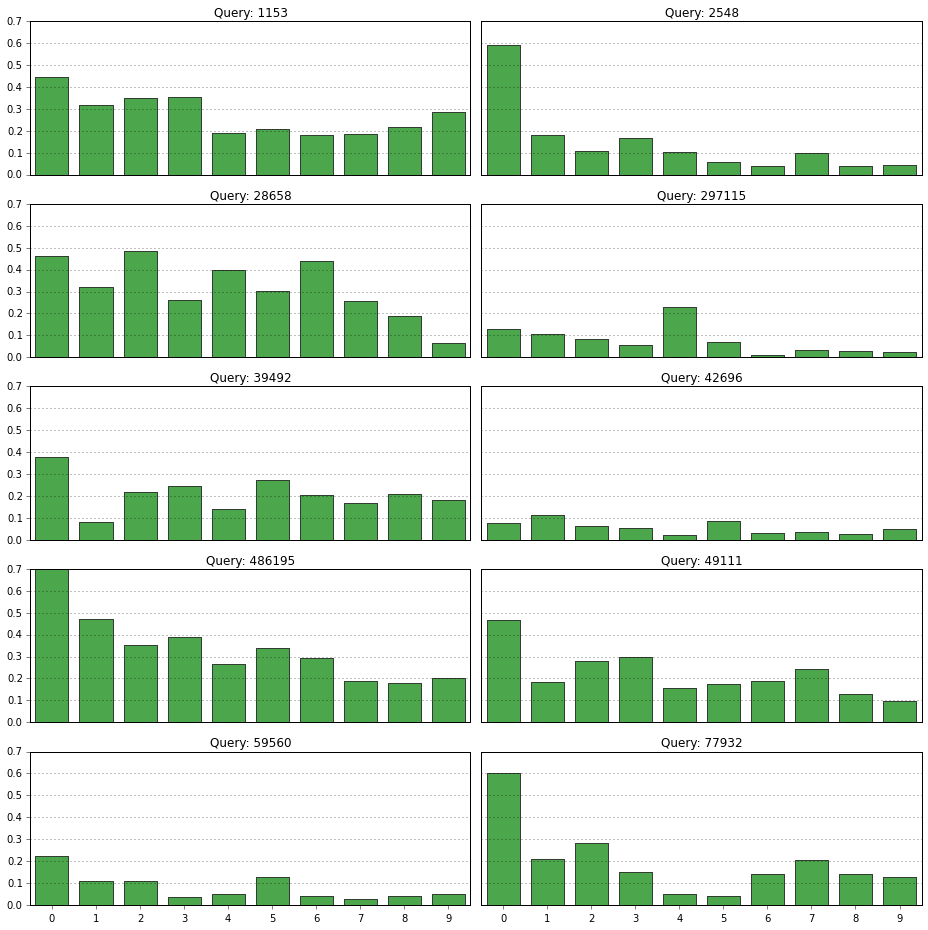

In [5]:
from ipywidgets import interact, interactive, Dropdown, FloatText, VBox, HBox

from IPython.display import display

def show_all_queries_relevances(click_model_name):
    fig, axes = plt.subplots(5, 2, figsize=(13, 13), sharex=True, sharey=True)

    for i, query in enumerate(sorted(MQD[click_model_name].keys())):
        ax = axes[i / 2, i % 2]

        relevances = MQD[click_model_name][query]['relevances']

        ax.bar(np.arange(len(relevances)), relevances, 0.75,
               alpha=0.7, color='green', align='center')

        ax.set_title('Query: %s' % query)
        ax.grid(axis='y', which='major')
        
        b = 'on' if i / 2 == 4 else 'off'
        lb = 'on' if i / 2 == 4 else 'off'
        l = 'on' if i % 2 == 0 else 'off'
        ll = 'on' if i % 2 == 0 else 'off'
                
        ax.tick_params(axis='both', which='major', left=l, direction='out',
                       top='off', right='off', bottom=b, labelleft=ll,
                       labeltop='off', labelright='off', labelbottom=lb)
            
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.set_xlim([-0.5, len(relevances) - 0.5])
    plt.tight_layout()
    plt.show(fig)

_ = interact(show_all_queries_relevances, click_model_name=Dropdown(options=MQD.keys(), description='Click Model:'))